In [6]:
import numpy as np
from pyDOE import lhs
from scipy.integrate import odeint

import matplotlib.pyplot as plt

# to use java in python 
# you need to install the package pyjnius
# you need to specify the path where is Java 
#import os

#os.environ['JAVA_HOME'] = "/Library/Java/JavaVirtualMachines/jdk-11.0.5.jdk/Contents/Home"
from moonlight import *

# importing the model, the simulation function
from pancreasModel import modelPID, simulation

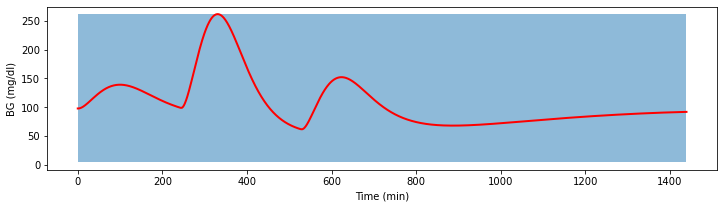

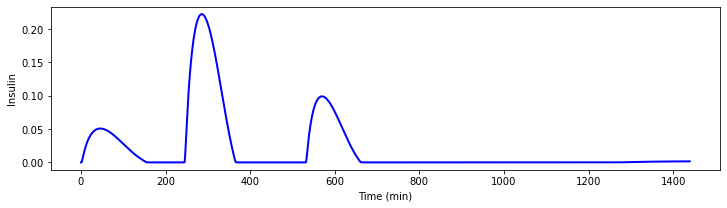

In [9]:
# setting the k_i parameters
Kd = [0, -0.0602, -0.0573, -0.06002, -0.0624]
Ki = [0, -3.53e-07, -3e-07, -1.17e-07, -7.55e-07]
Kp = [0, -6.17e-04, -6.39e-04, -6.76e-04, -5.42e-04]

pidC1 = lambda x, t: modelPID(x, t, Kp[1], Ki[1], Kd[1])
pidC2 = lambda x, t: modelPID(x, t, Kp[2], Ki[2], Kd[2])
pidC3 = lambda x, t: modelPID(x, t, Kp[3], Ki[3], Kd[3])
pidC4 = lambda x, t: modelPID(x, t, Kp[4], Ki[4], Kd[4])

pidC1Noise = lambda x, t: modelPID(x, t, Kp[1], Ki[1], Kd[1])

# defining the control parameters 
t_meal1 = np.random.normal(300, 60)
t_meal2 = np.random.normal(300, 60)
t_meal3 = 1440 - t_meal1 - t_meal2
dg1 = np.random.normal(40, 10)
dg2 = np.random.normal(90, 10)
dg3 = np.random.normal(60, 10)

# trying to vary oid constant pidC_i
t, y = simulation([t_meal1, t_meal2, t_meal3], [dg1, dg2, dg3], pidC2)
g = y[:,0];
u = y[:,-1];


# plot results
thresholdUp = 180;
thresholdDown = 70;

figsize = [12,3]
plt.subplots(figsize=figsize)
plt.fill_between([t[0],t[-1]], [4,4],[max(max(g),thresholdUp),max(max(g),thresholdUp)],alpha=0.5)
plt.plot(t,g,'r-',linewidth=2)
plt.xlabel('Time (min)')
plt.ylabel('BG (mg/dl)')
plt.show()

plt.subplots(figsize=figsize)
plt.plot(t,u,'b-',linewidth=2)
plt.xlabel('Time (min)')
plt.ylabel('Insulin')
plt.show()

In [11]:
# defining the properties
script = """
signal {real y;}
domain minmax; 
formula hypoGlicemia = globally [0.0, 1400]  (y > 70);
formula hyperGlicemia = globally [0.0, 1400]  (y < 230);
formula prolonged_hyperGlicemia = !{eventually[0,1000]{globally [0.0, 180]  (y > 180)}};
formula prolonged_hypoGlicemia = !{eventually[0,1000]{globally [0.0, 30]  (y < 70)}};
"""
moonlightScript = ScriptLoader.loadFromText(script)

# monitoring the properties
monitor = moonlightScript.getMonitor("prolonged_hyperGlicemia")
y_signal = [[yy] for yy in g]
result = monitor.monitor(list(t),y_signal)
print('\n','robustness:'+ str(result[0][1]),'\n') # robustness at time zero


 robustness:65.95488939995732 



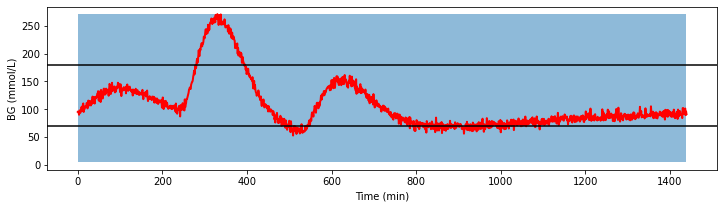


 robustness:74.36224783436693 



In [16]:
# noise model 
y_noise = [yy+ np.random.normal(0, 5) for yy in g]

plt.subplots(figsize=figsize)
plt.fill_between([t[0],t[-1]], [4,4],[max(max(y_noise),thresholdUp),max(max(y_noise),thresholdUp)],alpha=0.5)
plt.plot(t,y_noise,'r-',linewidth=2)
plt.axhline(y=thresholdUp, color='k', linestyle='-')
plt.axhline(y=thresholdDown, color='k', linestyle='-')
plt.xlabel('Time (min)')
plt.ylabel('BG (mmol/L)')
plt.show()
y_signal = [[yy] for yy in y_noise]
result = monitor.monitor(list(t),y_signal)
print('\n','robustness:'+ str(result[0][1]),'\n') # robustness at time zero

In [18]:
#falsification
def findMinimum(pid, N):
    minSTL = float('Inf')
    vRob = float('Inf')
    for i in range(N):
        t_meal1 = np.random.normal(300, 60)
        t_meal2 = np.random.normal(300, 60)
        t_meal3 = 1440 - t_meal1 - t_meal2
        dg1 = np.random.normal(40, 10)
        dg2 = np.random.normal(90, 10)
        dg3 = np.random.normal(60, 10)
        t, y = simulation([t_meal1, t_meal2, t_meal3], [dg1, dg2, dg3], pid)
        y = y[:, 0]
        y_signal = [[yy] for yy in y]
        result = monitor.monitor(list(t),y_signal)
        stl =  result[0][1]
        if (stl < minSTL):
            minSTL = stl
            vSTL = [t_meal1, t_meal2, t_meal3, dg1, dg2, dg3]
        if minSTL < 0:
            break

    print('minSTL parameter: ' + str(vSTL))
    print('minSTL: ' + str(minSTL))

N = 100;    
findMinimum(pidC1, N)


minSTL parameter: [111.95756575670396, 221.83675395068096, 1106.2056802926152, 45.20618321211613, 97.78556416843104, 68.07864905412116]
minSTL: 7.15493290652276
